# ***Movie Review Sentiment Analysis***

Anggota kelompok:
- 36240010 - Levingga Mettaliani
- 36240011 - Calsen Arlu
- 36240019 - Samuel Lie
- 36240021 - Cynthia Tipani Tio

Sebagai project UAS, kelompok kami ingin melakukan analisis sentimen dengan topik *Movie Review*. Kami ingin membuat sebuah aplikasi menggunakan *Streamlit* untuk melakukan prediksi sentimen dari komentar suatu film. Prediksi ini bertujuan untuk membantu mengetahui kualitas film secara cepat tanpa harus membaca ribuan komentar panjang. 

Kasus prediksi sentimen merupakan kasus **klasifikasi**, karena hasil (*output*) yang dikeluarkan oleh model berupa variabel **kategorikal**. Maka dari itu, diperlukan beberapa algoritma klasifikasi. Dalam kasus klasifikasi terdapat dua metode yang dapat digunakan untuk membuat model yaitu *Machine Learning* (ML) dan *Deep Learning* (DL) menggunakan *Neural Network*. Meskipun model *Deep Learning* dapat lebih baik dalam melakukan prediksi, namun kami memutuskan untuk menggunakan algoritma *Machine Learning*. Tujuannya karena *Machine Learning* lebih **sederhana**, **cepat** dalam proses *training*, dan **mudah dimengerti** daripada model *Deep Learning*.

Untuk membangun model *Machine Learning*, tentu diperlukan beberapa *library* untuk mempermudah dan menyerhanakan *code* dengan rincian dibawah ini.

In [ ]:
# Import library untuk mengakses dataset dan manipulasi data
import kagglehub
import pandas as pd
import os
import shutil

# Import library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import library untuk text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Import library untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Import library untuk membuat model machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import library untuk hyperparameter tuning, evaluasi, dan validasi model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

# Import library untuk menyimpan model
import pickle

# Import library untuk menghilangkan warning
import warnings
warnings.filterwarnings('ignore')

Dataset yang kami gunakan untuk project ini merupakan dataset yang bersumber dari **_Kaggle_** dengan link sebagai [berikut](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [2]:
# Mengunduh dataset dari Kaggle 
path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

# Mencari file CSV dalam folder yang diunduh
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])

# Menyalin file CSV ke folder dataset
file = os.path.join('dataset', csv_files[0])
shutil.copy(csv_path, file)

# Membaca dataset
data = pd.read_csv(file)

# Menampilkan 5 data paling atas pada dataset
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## ***Data Exploration* dan *Data Cleaning***

Tahap pertama dalam melakukan analisis sentimen adalah **mengetahui struktur dataset** melalui *data exploration*, kemudian dapat dilakukan *data cleaning* untuk membersihkan dataset dari data yang duplikat maupun data yang hilang agar dapat digunakan oleh algoritma *Machine Learning*.

In [3]:
# Menampilkan informasi pada dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Berdasarkan informasi diatas, diketahui bahwa dataset memiliki **2 kolom** dengan total **50.000 baris**. Artinya dataset ini **cukup besar**, sehingga cocok digunakan dalam analisis sentimen agar model dapat **belajar** dari banyaknya contoh-contoh yang sudah ada.

Selain itu, kedua kolom dari dataset ini memiliki **tipe data object (kategorikal)**. Artinya tipe datanya sudah **sesuai** untuk dilakukan analisis sentimen. Selain itu, keduanya juga memiliki *Non-Null Count* sebesar 50.000 yang berarti **tidak ada** kolom yang memiliki data yang hilang (*missing value*). 

In [4]:
# Menampilkan informasi dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
# Mengetahui jenis sentimen yang terdapat pada dataset
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Berdasarkan informasi diatas, diketahui bahwa untuk:
- Kolom `review` memiliki `unique` sebesar 49.582, hal ini dapat diindikasikan sebagai adanya **data yang duplikat**, karena secara logika harusnya komentar setiap orang pasti memiliki perbedaan baik sekecil apapun itu.
- Kolom sentiment memiliki `unique` sebesar 2, artinya kolom ini hanya berisikan sentimen "positif" dan "negatif", sehingga model *Machine Learning* kedepannya hanya bisa melakukan prediksi sentimen "positif" atau "negatif", bukan sentimen "netral".

Selain itu, jumlah sentimen positif dan negatif awalnya **sangat seimbang** (50:50).

In [6]:
# Menampilkan jumlah data yang hilang
data.isnull().sum()

review       0
sentiment    0
dtype: int64

Berdasarkan informasi diatas, terlihat bahwa dataset **tidak memiliki** data yang hilang (*missing values*).

In [7]:
# Menampilkan jumlah data yang duplikat
data.duplicated().sum()

418

Berdasarkan informasi diatas, terbukti bahwa dataset ini memiliki **data yang duplikat**, sehingga perlu dilakukan *data cleaning* dengan **menghapus** data yang duplikat. 

In [8]:
# Menghapus data yang duplikat
data.drop_duplicates(inplace=True)

# Mereset indeks setelah penghapusan agar tetap berurutan
data.reset_index(drop=True, inplace=True)

## ***Exploratory Data Analysis* (EDA)**

Tahap selanjutnya yaitu melakukan *Exploratory Data Analysis* (EDA). Pada tahap ini, akan dilakukan penyelidikan lebih lanjut mengenai **karakteristik dataset** melalui **visualisasi-visualisasi** yang ditampilkan. 

In [9]:
# Menampilkan informasi dataset
data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


Setelah dilakukan *data cleaning*, terlihat bahwa jumlah data berkurang menjadi 49.582 data yang dapat dilihat dari jumlah `count` dan `unique` yang sama.

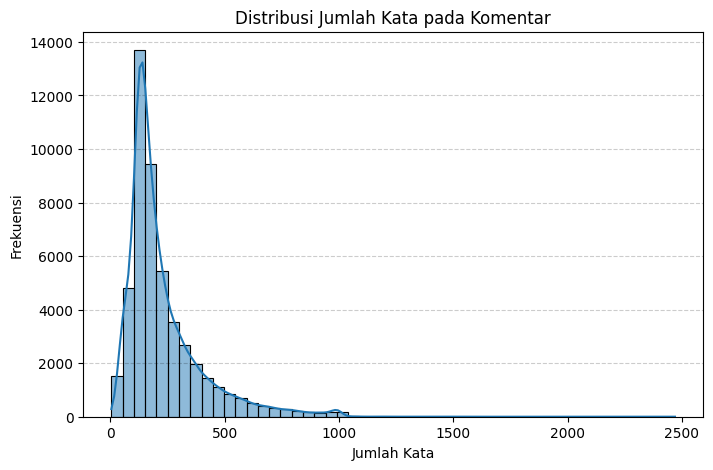

In [10]:
# Menampilkan distribusi jumlah kata pada komentar
plt.figure(figsize=(8,5))
sns.histplot(data['review'].apply(lambda x: len(x.split())), bins=50, kde=True)
plt.grid(axis='y', color='black', alpha=0.2, linestyle='--')
plt.title('Distribusi Jumlah Kata pada Komentar')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

Berdasarkan grafik diatas, diketahui bahwa jumlah kata memiliki distribusi yang bersifat *right-skewed*. Artinya, dapat diasumsikan kebanyakan orang memberikan komentar secara **_to-the-point_** dengan jumlah kata yang **sedikit (pendek)**, sementara hanya sedikit sekali yang memberikan komentar dengan jumlah kata yang banyak (panjang).

In [11]:
# Menampilkan jumlah sentimen positif dan negatif
data['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

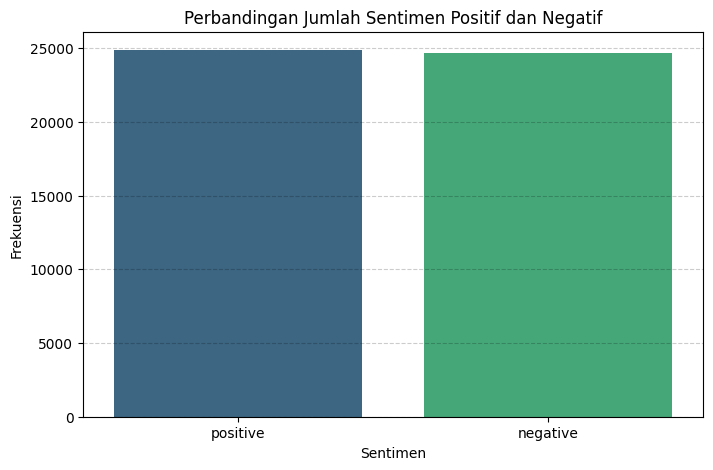

In [12]:
# Menampilkan perbandingan jumlah sentimen positif dan negatif
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='sentiment', palette='viridis')
plt.grid(axis='y', color='black', alpha=0.2, linestyle='--')
plt.title('Perbandingan Jumlah Sentimen Positif dan Negatif')
plt.xlabel('Sentimen')
plt.ylabel('Frekuensi')
plt.show()

Berdasarkan informasi dan grafik diatas, terlihat bahwa distribusi jumlah kata pada masing-masing sentimen **hampir seimbang**. Artinya model akan belajar dari setiap sentimen dengan **proporsi yang seimbang**, sehingga model tidak akan lebih dominan dalam mempelajari data dengan sentimen positif maupun negatif.

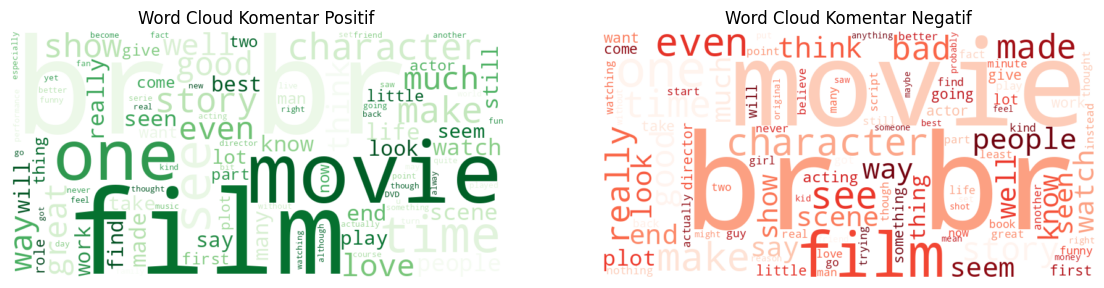

In [13]:
# Membuat WordCloud
positive = [data['review'][i] for i in range(len(data)) if data['sentiment'][i] == 'positive']
negative = [data['review'][i] for i in range(len(data)) if data['sentiment'][i] == 'negative']
positive = ' '.join(positive)
negative = ' '.join(negative)

# Membuat WordCloud untuk data positif dan negatif
wc_pos = WordCloud(width=800, height=400, background_color='white',
                   colormap='Greens', max_words=100).generate(positive)
# WordCloud untuk data negatif
wc_neg = WordCloud(width=800, height=400, background_color='white',
                   colormap='Reds', max_words=100).generate(negative)

# Menampilkan WordCloud
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Komentar Positif')
plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Komentar Negatif')
plt.show()

Berdasarkan *wordcloud* diatas, terlihat bahwa pada *wordcloud* positif, terdapat kata-kata yang menunjukkan bahwa kualitas film itu bagus, seperti `good`, `great`, dan `love`. Sebaliknya, pada *wordcloud* negatif, terdapat kata-kata yang menunjukkan bahwa kualitas film itu buruk, seperti `bad`, `never`, dan `nothing`. Tetapi, pada *wordcloud* negatif masih memiliki kata-kata positif seperti `great` dan `love` dikarenakan kata-kata tersebut **hanya potongan** dari sebagian besar komentar.

Namun perlu diketahui bahwa pada kedua *wordcloud*, kata-kata yang berukuran besar belum tentu menggambarkan komentar positif maupun negatif. Contohnya seperti kata `film`, `movie`, dan `character`. Ketiganya tidak menggambarkan komentar positif maupun negatif, namun kata-kata tersebut umum ditemui pada kedua sentimen, sesuai dengan datasetnya yang membahas mengenai kualitas film.

Selain itu, terdapat masalah utama yang harus dihadapi yaitu terdapat banyak kata-kata tidak bermakna seperti `br`, sehingga kata tersebut perlu dihapus melalui proses *text preprocessing*.

## ***Text Preprocessing***

*Text preprocessing* merupakan teknik untuk membersihkan dan mengubah teks mentah menjadi hasil yang lebih bermakna sehingga dapat diolah dengan efektif dan akurat. Teknik ini bertujuan untuk memastikan bahwa dataset yang digunakan oleh model sudah **benar-benar merepresentasikan** setiap sentimen tanpa adanya kata-kata tidak bermakna (*noise*). Model hanya melihat teks sebagai urutan simbol dalam ASCII code.

Melihat kembali dataset yang digunakan, maka akan ditemukan beberapa masalah seperti adanya tag HTML seperti `<br />` dan URL seperti `www.cei.org/pdf/5539.pdf`. Maka dari itu perlu dilakukan *text cleaning*.

### *Text Cleaning*

*Text cleaning* bertujuan untuk membersihkan *string* dari karakter yang **tidak memberikan informasi** apapun. Tahap ini akan mengubah semua huruf menjadi **huruf kecil**, karena model *Machine Learning* akan menanggap huruf kecil dan huruf besar itu **berbeda** sesuai ASCII code-nya. Selanjutnya tahap ini akan membersihkan komentar dari *string* yang tidak memberikan informasi penting seperti **tag HTML**, **URL**, dan **tanda baca**. Selain itu, tahap ini juga memastikan karakter yang digunakan hanyalah berupa **huruf** tanpa adanya spasi berlebih.

In [14]:
# Membuat fungsi text cleaning
def text_cleaning(text):
    # Mengubah text ke lowercase
    text = text.lower()
    # Menghapus tag HTML
    text = re.sub(r'<.*?>', ' ', text)
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Menghapus karakter selain huruf dan spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

Setelah dilakukan *text cleaning*, komentar sekarang sudah sudah jauh lebih bersih. Namun untuk memperdalam makna setiap kata, perlu dilakukan penghapusan terhadap *stopword* dan melakukan *lemmatization*.

### Menghapus *Stopword* dan Tahap *Lemmatization*

*Stopword* merupakan kata-kata yang tidak memiliki makna apapun seperti `the`, `is`, `a`, dan sebagainya. Kata-kata ini tidak memiliki arti yang spesifik sehingga perlu dihapus karena tidak berguna bagi pembelajaran model. Namun perlu diketahui bahwa pada library NLTK, terdapat beberapa *stopword* yang harus dipertahankan seperti `no`, `didn't`, dan kata-kata lainnya yang berpengaruh terhadap makna kalimat. Sebagai contoh, pada kalimat `The movie is not good`, jika kata-kata seperti `is` dan `not` dihapus, maka kalimatnya menjadi `movie good` yang justru merubah sentimen menjadi positif.

*Lemmatization* merupakan proses untuk menyederhanakan kata dengan **_mempertimbangkan konteks dan makna kata_** untuk mengembalikan kata pada bentuk dasarnya. Sebagai contoh, kata `better` dan `best` keduanya dapat disederhanakan menjadi kata `good`. 

In [15]:
# Mengunduh Resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Inisialisasi tools untuk menghapus stopwords
stopwords_english = set(stopwords.words('english')) # Stopword umum dalam bahasa Inggris
negative_words = {"no", "not", "nor", "don", "don't", "ain", "aren", "aren't", # Stopword negatif yang ingin dipertahankan
                  "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", 
                  "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", 
                  "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't", 
                  "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", 
                  "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"} 
list_stopwords = stopwords_english - negative_words

# Inisialisasi tools untuk melakukan lemmatization
lemmatizer = WordNetLemmatizer()

# Membuat fungsi untuk mengubah Tag NLTK ke WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\light\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\light\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\light\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\light\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\light\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\light\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

Untuk melakukan kedua tahap ini, setiap komentar perlu dipecah menjadi **list kata** yang disebut sebagai **tokenisasi**. Setiap kata pada list kemudian akan dilakukan pemeriksaan **jenis kata** untuk mengetahui apakah kata tersebut termasuk dalam `verb`, `adjective`, `noun`, dan `sebagainya`. Selanjutnya barulah dilakukan pemeriksaan apakah kata tersebut merupakan *stopword* dan adakah bentuk yang lebih sederhananya (*lematization*).

In [ ]:
# Membuat fungsi menghapus stopwords dan melakukan lemmatization
def stopwords_lematization(text):
    # Melakukan tokenisasi dengan memecah teks menjadi list kata
    tokens = word_tokenize(text)
    # Melakukan POS Tagging pada tokens
    pos_tags = nltk.pos_tag(tokens)
    clean_tokens = []
    # Melakukan penghapusan stopwords dan lemmatization
    for word, tag in pos_tags:
        if word not in list_stopwords and len(word) > 1: # Menghapus kata yang sangat pendek seperti br
            wn_pos = get_wordnet_pos(tag)
            # Melakukan lemmatization sesuai jenis katanya            
            lemma = lemmatizer.lemmatize(word, pos=wn_pos)
            clean_tokens.append(lemma)
    # Menggabungkan kembali kata-kata menjadi teks
    return ' '.join(clean_tokens)

Sekarang, fungsi untuk melakukan *text preprocessing* sudah siap dengan menggabungkan antara *text cleaning*, penghapusan *stopword*, dan *lemmatization*.

In [17]:
# Membuat fungsi text preprocessing
def text_preprocessing(text):
    # Text Cleaning
    text = text_cleaning(text)
    # Menghapus Stopwords dan Lemmatization
    text = stopwords_lematization(text)
    return text

In [18]:
# Menerapkan text preprocessing terhadap dataset
data['review'] = data['review'].apply(text_preprocessing)

# Menyimpan dataset yang sudah diproses ke file CSV baru
data.to_csv('dataset/IMDB Dataset Preprocessed.csv', index=False)

# Menampilkan 5 data paling atas setelah preprocessing
data.head()

,review,sentiment
0,one reviewer mention watch oz episode youll ho...,positive
1,wonderful little production filming technique ...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically theres family little boy jake think ...,negative
4,petter matteis love time money visually stunni...,positive


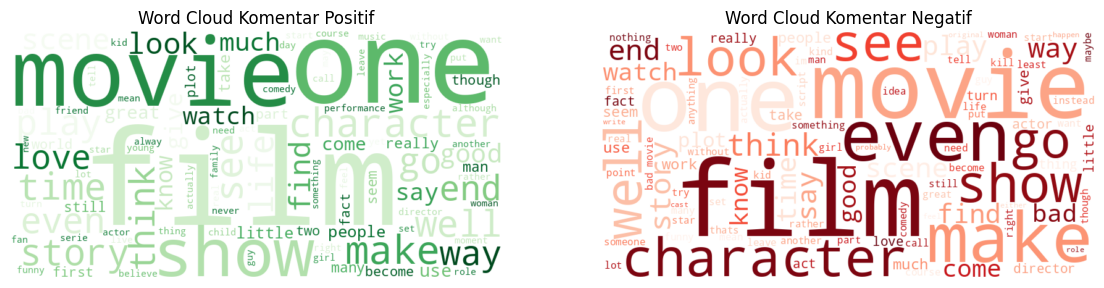

In [19]:
# Membuat WordCloud
positive = [data['review'][i] for i in range(len(data)) if data['sentiment'][i] == 'positive']
negative = [data['review'][i] for i in range(len(data)) if data['sentiment'][i] == 'negative']
positive = ' '.join(positive)
negative = ' '.join(negative)

# Membuat WordCloud untuk data positif dan negatif
wc_pos = WordCloud(width=800, height=400, background_color='white',
                   colormap='Greens', max_words=100).generate(positive)
# WordCloud untuk data negatif
wc_neg = WordCloud(width=800, height=400, background_color='white',
                   colormap='Reds', max_words=100).generate(negative)

# Menampilkan WordCloud
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Komentar Positif')
plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Komentar Negatif')
plt.show()

Berdasarkan *wordcloud* diatas, terlihat bahwa bahwa proses *text preprocessing* memberikan hasil yang cukup baik. Hal ini dapat dilihat dari kata `br` yang sudah hilang. Artinya, dataset siap digunakan untuk tahap selanjutnya.

## **Membuat Model *Machine Learning***

Setelah dataset dilakukan *preprocessing*, maka diperoleh dataset sudah memiliki komentar yang mencerminkan suatu sentimen. Sesuai dengan tujuan awal, yaitu untuk melakukan prediksi sentimen, maka variabel `sentimen` akan dijadikan sebagai variabel target atau `y`. Sedangkan, variabel `review` akan digunakan sebagai variabel prediktor atau `X`.

Namun, perlu diketahui bahwa model *machine learning* **tidak memahami bahasa manusia secara langsung** sehingga perlu dilakukan ***encoding*** untuk variabel `sentimen` dan **vektorisasi** untuk variabel `review`.

In [20]:
# Import dataset yang sudah dibersihkan
data = pd.read_csv('dataset/IMDB Dataset preprocessed.csv')

# Membagi dataset menjadi variabel prediktor (X) dan target (y)
X = data['review']
y = data['sentiment'].map({'positive': 1, 'negative': 0}) # Melakukan encoding untuk variabel target

# Membagi dataset menjadi data training (80%) dan data testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Menampilkan jumlah data training dan data testing
print(f'Jumlah data training : {X_train.shape[0]}')
print(f'Jumlah data testing  : {X_test.shape[0]}')

Jumlah data training : 39665
Jumlah data testing  : 9917


### Vektorisasi

Vektorisasi merupakan **proses mengubah setiap kata menjadi nilai numerik** agar model *Machine Learning* dapat memahami dan memproses setiap kata secara lebih efektif. Proses ini dilakukan **setelah** pembagian data training dan data testing yang bertujuan untuk **menghindari kebocoran data (*data leakage*)** akibat model mengetahui kata-kata pada data testing. 

Terdapat beberapa teknik vektorisasi yang dapat dilakukan, namun pada proyek ini kami menggunakan ***Term Frequency–Inverse Document Frequency* (TF-IDF)**. Alasan dipilihnya TF-IDF berkaitan dengan distribusi data yang bersifat *right-skewed*, di mana terdapat kesenjangan antara kebanyakan orang yang berkomentar pendek terhadap yang berkomentar panjang. Tanpa menggunakan TF-IDF, model linier seperti Logistic Regression akan cenderung memberikan nilai berlebih pada komentar panjang hanya karena tingginya frekuensi kemunculan kata (misalnya kata `good` muncul 20 kali), padahal belum tentu komentar tersebut lebih penting daripada komentar pendek yang padat. Selain itu, komponen IDF (*Inverse Document Frequency*) secara otomatis akan menurunkan nilai kata-kata umum yang mendominasi dataset tetapi kurang bermakna (seperti `movie`, `film`, atau `watch`), sehingga model dipaksa untuk belajar dari kata-kata yang menjadi pembeda antara sentimen positif dan negatif.

TF-IDF bekerja dengan cara memberikan nilai numerik pada setiap kata berdasarkan **seberapa sering kata itu muncul dalam sebuah teks (TF / *Term Frequency*)**  yang dikalikan dengan **seberapa jarang kata itu muncul di seluruh teks (IDF / *Inverse Document Frequency*)**. Artinya, semakin tinggi nilai numerik suatu kata, maka semakin penting atau representatif kata tersebut untuk komentar tersebut (kata itu sering muncul di komentar tersebut tetapi relatif jarang muncul di komentar lain).

Secara matematis, pemberian nilai pada TF-IDF menggunakan rumus dasar sebagai berikut:

$$
\text{TF-IDF}= \text{TF}\times \ln\left(\frac{N}{df}\right)
$$

Keterangan:
- N  : Jumlah komentar pada dataset
- df : Jumlah komentar yang mengandung kata terkait

In [21]:
# Inisialisasi TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000) 

# Melakukan vektorisasi pada variabel prediktor menggunakan TF-IDF
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Perlu diketahui bahwa pembatasan `max_features` menjadi 5.000 bertujuan agar model dapat **berfokus** untuk belajar dari kata-kata yang memiliki **informasi penting**, sehingga *noise* dapat dihilangkan untuk mencegah *overfitting*. Selain itu, pembatasan ini juga bertujuan untuk menghemat penggunaan memori dan mempercepat waktu training.

### *Modelling* dan Evaluasi

Setelah variabel dilakukan *encoding*, data *split*, dan vektorisasi, barulah proses permodelan dapat dimulai. Pada proyek ini, kami menggunakan 3 jenis model yang akan dibandingkan. Berikut adalah model yang kami gunakan:
- *Logistic Regression*
- *Naive Bayes*
- *Random Forest Classifier*

Perlu diketahui bahwa dataset yang digunakan memiliki perbandingan sentimen positif dan negatif yang **seimbang**. Artinya, **akurasi** merupakan metrik evaluasi yang akan dilakukan perbandingan karena mencerminkan performa model yang sebenarnya.

#### ***Logistic Regression***

Classification Report:

              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      4940
    positive       0.88      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



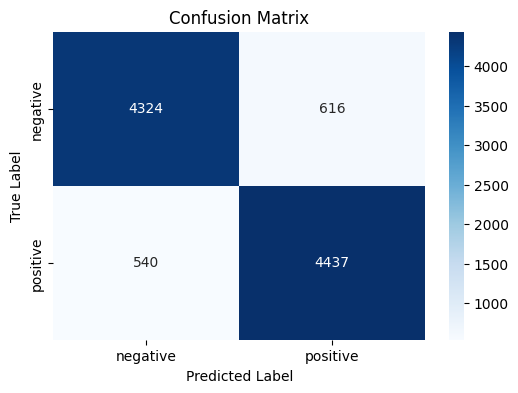

In [22]:
# Membangun model Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Melatih model Logistic Regression
log_reg.fit(X_train, y_train)

# Evaluasi model
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Classification Report:\n')
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Menampilkan Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

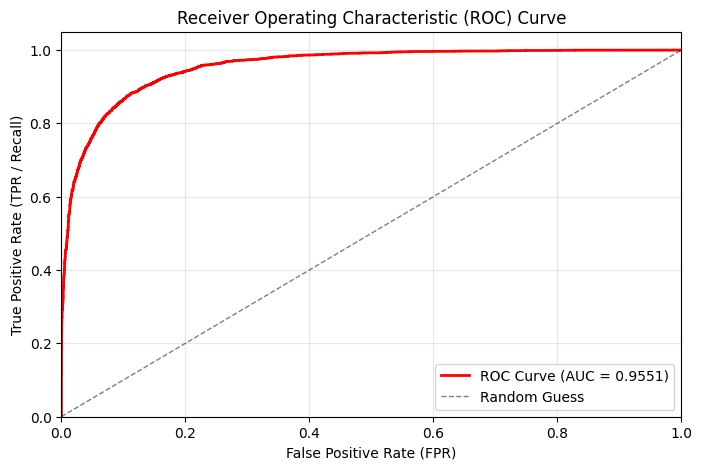

Nilai AUC: 0.9551


In [23]:
# Menghitung probabilitas prediksi
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Menghitung FPR dan TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Menampilkan ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.5, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
print(f'Nilai AUC: {roc_auc:.4f}')

In [24]:
# Melakukan K-fold cross validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print(f'Akurasi setiap Fold     : {cv_scores}')
print(f'Rata-rata Akurasi       : {cv_scores.mean():.4f}')
print(f'Standar Deviasi Akurasi : {cv_scores.std():.4f}') 

Akurasi setiap Fold     : [0.88692802 0.88087735 0.88352452 0.88692802 0.8798689 ]
Rata-rata Akurasi       : 0.8836
Standar Deviasi Akurasi : 0.0029


Berdasarkan hasil *k-fold cross validation*, diketahui bahwa model memiliki selisih yang sangat kecil antara akurasi ketika di-*training* dan rata-rata akurasi ketika divalidasi (dengan standar deviasi yang kecil). Artinya, model tidak mengalami *overfitting* dan mampu melakukan generalisasi dengan baik.

#### ***Naive Bayes***

Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4940
    positive       0.85      0.85      0.85      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



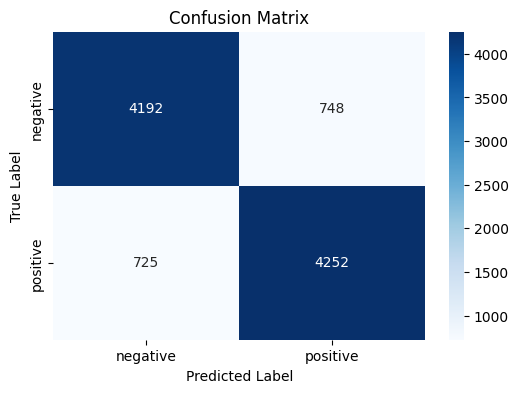

In [25]:
# Membangun model Naive Bayes
naive_bayes = MultinomialNB()

# Melatih model Naive Bayes
naive_bayes.fit(X_train, y_train)

# Evaluasi model
y_pred = naive_bayes.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Classification Report:\n')
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Menampilkan Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

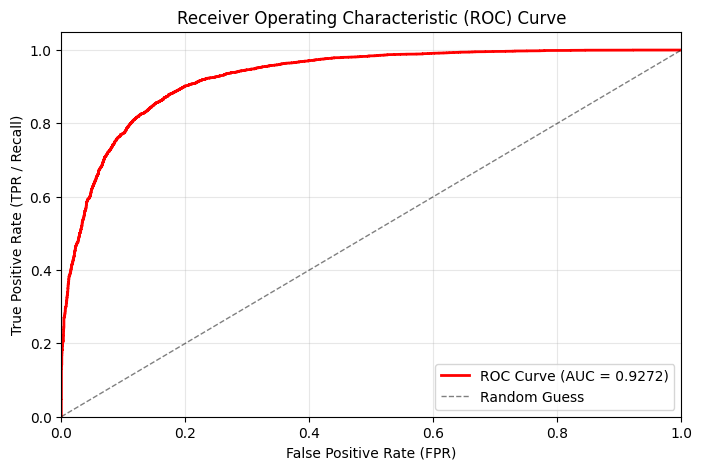

Nilai AUC: 0.9272


In [26]:
# Menghitung probabilitas prediksi
y_pred_proba = naive_bayes.predict_proba(X_test)[:, 1]

# Menghitung FPR dan TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Menampilkan ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.5, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
print(f'Nilai AUC: {roc_auc:.4f}')

In [27]:
# Melakukan K-fold cross validation
cv_scores = cross_val_score(naive_bayes, X_train, y_train, cv=5, scoring='accuracy')
print(f'Akurasi setiap Fold     : {cv_scores}')
print(f'Rata-rata Akurasi       : {cv_scores.mean():.4f}')
print(f'Standar Deviasi Akurasi : {cv_scores.std():.4f}') 

Akurasi setiap Fold     : [0.85024581 0.8499937  0.84772469 0.84974159 0.85276692]
Rata-rata Akurasi       : 0.8501
Standar Deviasi Akurasi : 0.0016


Berdasarkan hasil *k-fold cross validation*, diketahui bahwa model memiliki selisih yang sangat kecil antara akurasi ketika di-*training* dan rata-rata akurasi ketika divalidasi (dengan standar deviasi yang kecil). Artinya, model tidak mengalami *overfitting* dan mampu melakukan generalisasi dengan baik.

#### ***Random Forest Classifier***

In [28]:
# Menentukan parameter untuk Hyperparameter Tuning
parameters = {
    'n_estimators': [50, 100, 200],   # Jumlah tree
    'max_depth': [None, 10, 20, 30],  # Kedalaman maksimum tree
    'min_samples_split': [2, 5, 10],  # Jumlah minimal sampel untuk memecah node
    'criterion': ['gini', 'entropy']  # Metode pengukuran kualitas split
}

In [29]:
# Membuat model dasar random forest
rf_base = RandomForestClassifier(random_state=42)

# Mencari kombinasi parameter terbaik
grid_search = GridSearchCV(estimator=rf_base, param_grid=parameters, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Melatih model dengan kombinasi parameter
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik dan model terbaik
print(f'Parameter terbaik : {grid_search.best_params_}')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Parameter terbaik : {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      4940
    positive       0.85      0.85      0.85      4977

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



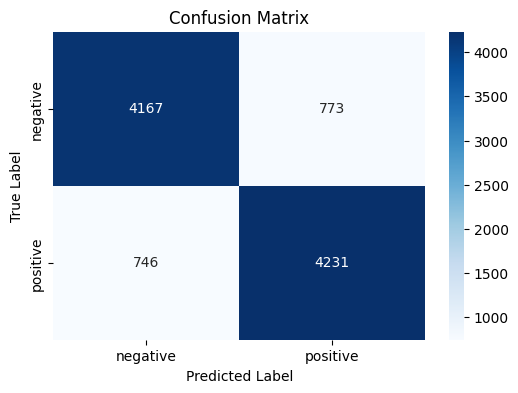

In [30]:
# Evaluasi model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Classification Report:\n')
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Menampilkan Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

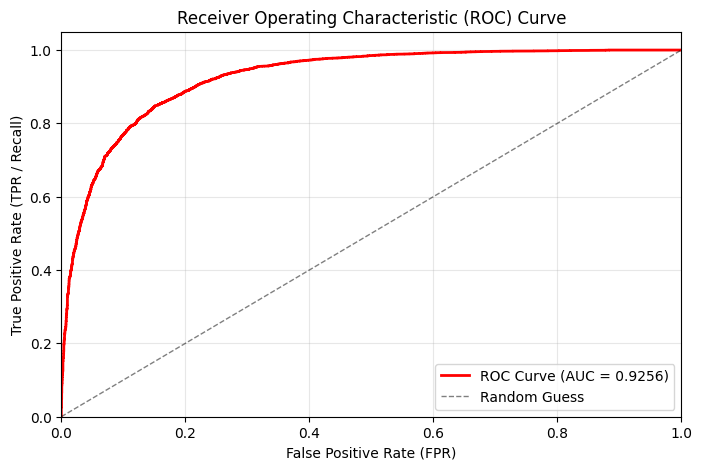

Nilai AUC: 0.9256


In [31]:
# Menghitung probabilitas prediksi
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Menghitung FPR dan TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Menampilkan ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.5, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
print(f'Nilai AUC: {roc_auc:.4f}')

In [32]:
# Melakukan K-fold cross validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Akurasi setiap Fold     : {cv_scores}')
print(f'Rata-rata Akurasi       : {cv_scores.mean():.4f}')
print(f'Standar Deviasi Akurasi : {cv_scores.std():.4f}') 

Akurasi setiap Fold     : [0.84646414 0.84381697 0.84848103 0.84696836 0.85289298]
Rata-rata Akurasi       : 0.8477
Standar Deviasi Akurasi : 0.0030


Berdasarkan hasil *k-fold cross validation*, diketahui bahwa model memiliki selisih yang sangat kecil antara akurasi ketika di-*training* dan rata-rata akurasi ketika divalidasi (dengan standar deviasi yang kecil). Artinya, model tidak mengalami *overfitting* dan mampu melakukan generalisasi dengan baik.

## **Keputusan Pemilihan Model**

Berdasarkan *confusion matrix* dari ketiga model, diketahui bahwa model *logistic regression* memiliki **akurasi yang paling tinggi** (sebesar 88%). Selain itu, model juga memiliki jumlah prediksi yang tepat (True Positive dan True Negative) yang jauh lebih banyak dibandingkan dengan kesalahan prediksinya (False Positive dan False Negative). Hal ini menunjukkan bahwa model mampu membedakan sentimen positif dan negatif secara efektif dan seimbang. 

Selain itu, dengan melihat grafik ROC *curve* dari ketiga model, diketahui bahwa model *logistic regression* memiliki nilai AUC sebesar 0,9551 yang menunjukkan bahwa model mampu membedakan sentimen positif dan negatif dengan **sangat baik**. Hal ini dapat dilihat dari kurva yang melengkung mendekati sudut kiri atas dan menjauhi garis diagonal (*random guess*). 

Melalui kedua pertimbangan tersebut, maka kami memilih untuk menggunakan model ***logistic regression*** sebagai model **terbaik** untuk melakukan prediksi sentimen yang akan digunakan pada *streamlit*.

## **Menyimpan *Vektorizer* dan Model Terbaik**

Tahap terakhir dalam analisis ini adalah menyimpan *vektorizer* TF-IDF dan menyimpan model terbaik pada folder yang sudah ditentukan.

In [ ]:
# Menyimpan vectorizer TF-IDF
with open('source/vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [ ]:
# Menyimpan model terbaik
with open('source/logistic_model.pkl', 'wb') as model_file:
    pickle.dump(log_reg, model_file)